In [18]:
import pandas as pd

# ---------- Helper functions ----------

def clean_simple(path, country="Germany"):
    """Clean simple datasets (B6N, PPS, num_hhld)"""
    df = pd.read_csv(path)
    df = df[df.iloc[:,0] == country]
    df = df.melt(id_vars=df.columns[0], var_name="Year", value_name="Value")
    df["Year"] = df["Year"].astype(int)
    df["Value"] = pd.to_numeric(df["Value"].astype(str).str.replace(",", "", regex=False), errors="coerce")
    df = df.rename(columns={df.columns[0]:"Country"})
    return df.reset_index(drop=True)

def clean_quintile(path, quintile, country="Germany"):
    df = pd.read_csv(path)
    df = df[df.iloc[:,0].str.contains(country, case=False, na=False)]

    # Melt wide → long
    df = df.melt(id_vars=df.columns[0], var_name="Year", value_name="Value")

    # Extract 4-digit year and drop rows without year
    df["Year"] = df["Year"].astype(str).str.extract(r"(\d{4})")[0]
    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)

    # Clean Values and drop NaN
    df["Value"] = pd.to_numeric(df["Value"].astype(str).str.replace(",", "", regex=False).replace(":", pd.NA), errors="coerce")
    df = df.dropna(subset=["Value"])

    # Add Quintile/Group only if numeric
    df["Quintile"] = quintile
    # For merging/expenditure, only keep numeric quintiles when needed
    # df["Quintile"] = pd.to_numeric(df["Quintile"], errors="coerce")

    df = df.rename(columns={df.columns[0]:"Country"})
    return df.reset_index(drop=True)

In [19]:
datasets = {}

# Simple datasets
datasets["b6n"] = clean_simple("B6N.csv", country="DE")
datasets["pps"] = clean_simple("PPS.csv", country="Germany")
datasets["hhld_num"] = clean_simple("num_hhld.csv", country="Germany")

# Income quintiles
income_parts = [clean_quintile(f"Inc{i}.csv", quintile=i) for i in range(1,6)]
datasets["income"] = pd.concat(income_parts, ignore_index=True)

# Expenditure quintiles + total
exp_parts = [clean_quintile(f"Exp{i}.csv", quintile=i) for i in range(1,6)]
exp_parts.append(clean_quintile("ExpTot.csv", quintile="Total"))
datasets["expenditure"] = pd.concat(exp_parts, ignore_index=True)


In [20]:
for key in ["income", "b6n", "hhld_num"]:
    datasets[key]["Country"] = "Germany"

In [21]:
# ==============================
# Mean Income per Household by Quintile
# ==============================

# Merge income shares with total income and household numbers
df_income = datasets["income"].merge(
    datasets["b6n"], on=["Country","Year"], suffixes=("_share","_total")
).merge(
    datasets["hhld_num"], on=["Country","Year"]
)

df_income = df_income.rename(columns={
    "Value_share":"IncomeShare",
    "Value_total":"TotalIncome_MIOEUR",  # millions of EUR
    "Value":"NumHouseholds_thousands"    # thousands
})

# --- Step 1: Total income per quintile (EUR) ---
df_income["Income_quintile"] = (
    df_income["TotalIncome_MIOEUR"] * 1_000_000 * df_income["IncomeShare"] / 100
)

# --- Step 2: Households per quintile ---
df_income["HH_quintile"] = (
    df_income["NumHouseholds_thousands"] * 1000 * 0.2
)

# --- Step 3: Mean income per household (EUR) ---
df_income["MeanIncome"] = df_income["Income_quintile"] / df_income["HH_quintile"]

# Keep only relevant columns
income_df = df_income[["Country", "Year", "Quintile", "MeanIncome"]].copy()
income_df["Quintile"] = income_df["Quintile"].astype(int)

# --- Sanity check ---
# Overall avg income = total disposable income / total households
df_income["Overall_AvgIncome"] = (
    df_income["TotalIncome_MIOEUR"] * 1_000_000 /
    (df_income["NumHouseholds_thousands"] * 1000)
)

print("Sanity check (overall average household income):")
print(df_income[["Year","Overall_AvgIncome"]].drop_duplicates().head())

print("\nSample of mean income by quintile:")
print(income_df.head())

Sanity check (overall average household income):
   Year  Overall_AvgIncome
0  2006       36979.368948
1  2007       37451.852229
2  2008       37950.345809
3  2009       38049.965036
4  2010       39441.406644

Sample of mean income by quintile:
   Country  Year  Quintile    MeanIncome
0  Germany  2006         1  16455.819182
1  Germany  2007         1  14606.222369
2  Germany  2008         1  15369.890053
3  Germany  2009         1  15980.985315
4  Germany  2010         1  16565.390790


In [22]:
expenditure = datasets["expenditure"]
pps = datasets["pps"]
hhld = datasets["hhld_num"]

# Merge expenditure shares with PPS
df_exp = expenditure.merge(pps, on=["Country","Year"], suffixes=("_Exp","_PPP"))

# Merge with household numbers
df_exp = df_exp.merge(hhld, on=["Country","Year"])
df_exp = df_exp.rename(columns={
    "Value_Exp":"ExpPPS",
    "Value":"NumHouseholds",
    "Value_PPP":"PPP"
})

# Convert PPS → Euro per household
df_exp["MeanExpenditure"] = df_exp["ExpPPS"] * df_exp["PPP"]

# Keep only numeric quintiles (exclude "Total")
df_exp = df_exp[df_exp["Quintile"].apply(lambda x: str(x).isdigit())]
df_exp["Quintile"] = df_exp["Quintile"].astype(int)

# Keep only needed columns
exp_df = df_exp[["Country","Year","Quintile","MeanExpenditure"]].copy()

print(exp_df.head())


   Country  Year  Quintile  MeanExpenditure
0  Germany  2010         1      12803.37240
1  Germany  2015         1      14122.97750
2  Germany  2020         1      15244.00192
3  Germany  2010         2      19466.80242
4  Germany  2015         2      22022.23380


In [23]:
income_df["Country"] = "Germany"
exp_df["Country"] = "Germany"


In [24]:
income_df = income_df[income_df["Quintile"].apply(lambda x: str(x).isdigit())].copy()
income_df["Quintile"] = income_df["Quintile"].astype(int)
exp_df = exp_df[exp_df["Quintile"].apply(lambda x: str(x).isdigit())].copy()
exp_df["Quintile"] = exp_df["Quintile"].astype(int)

In [25]:
df_compare = income_df.merge(exp_df, on=["Country","Year","Quintile"])
df_compare["Income_Exp_Ratio"] = df_compare["MeanExpenditure"] / df_compare["MeanIncome"]

print(df_compare.head())


   Country  Year  Quintile    MeanIncome  MeanExpenditure  Income_Exp_Ratio
0  Germany  2010         1  16565.390790      12803.37240          0.772899
1  Germany  2015         1  16460.204110      14122.97750          0.858007
2  Germany  2020         1  19205.257590      15244.00192          0.793741
3  Germany  2010         2  26820.156518      19466.80242          0.725827
4  Germany  2015         2  28128.196896      22022.23380          0.782924


In [26]:
print(datasets["b6n"].head())

   Country  Year    Value
0  Germany  2000  1278775
1  Germany  2001  1338270
2  Germany  2002  1337768
3  Germany  2003  1369347
4  Germany  2004  1395083


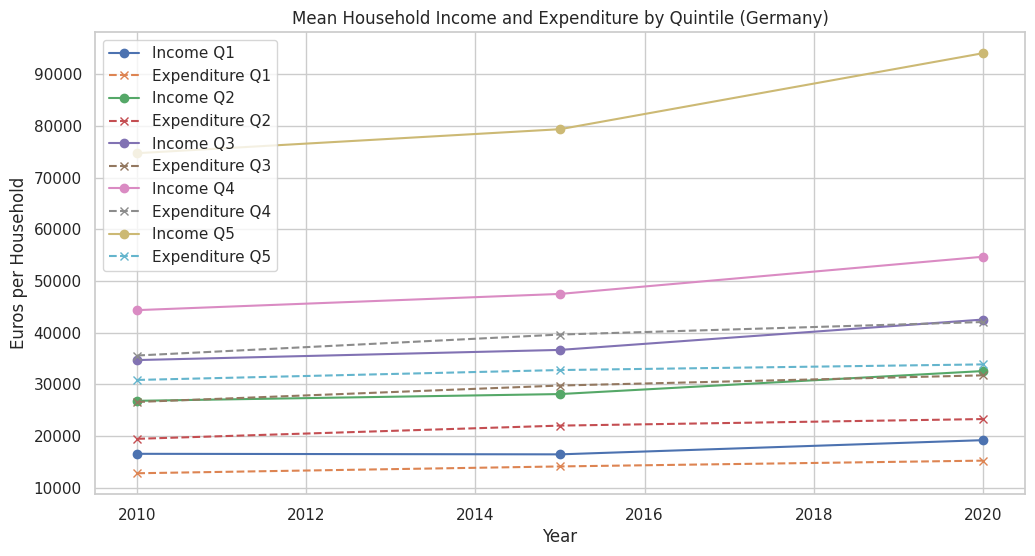

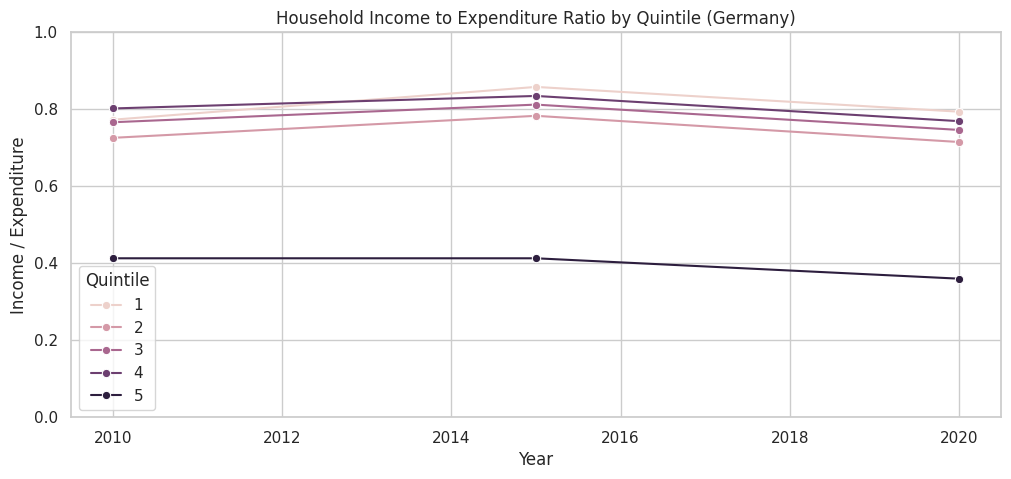

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")

# Plot MeanIncome and MeanExpenditure by quintile over time
plt.figure(figsize=(12,6))
for q in sorted(df_compare["Quintile"].unique()):
    subset = df_compare[df_compare["Quintile"] == q]
    plt.plot(subset["Year"], subset["MeanIncome"], marker='o', label=f'Income Q{q}')
    plt.plot(subset["Year"], subset["MeanExpenditure"], marker='x', linestyle='--', label=f'Expenditure Q{q}')

plt.title("Mean Household Income and Expenditure by Quintile (Germany)")
plt.xlabel("Year")
plt.ylabel("Euros per Household")
plt.legend()
plt.show()

# Plot Income/Expenditure ratio
plt.figure(figsize=(12,5))
sns.lineplot(data=df_compare, x="Year", y="Income_Exp_Ratio", hue="Quintile", marker="o")
plt.title("Household Income to Expenditure Ratio by Quintile (Germany)")
plt.ylabel("Income / Expenditure")
plt.xlabel("Year")
plt.ylim(0, 1)  # optional to keep ratio readable
plt.show()

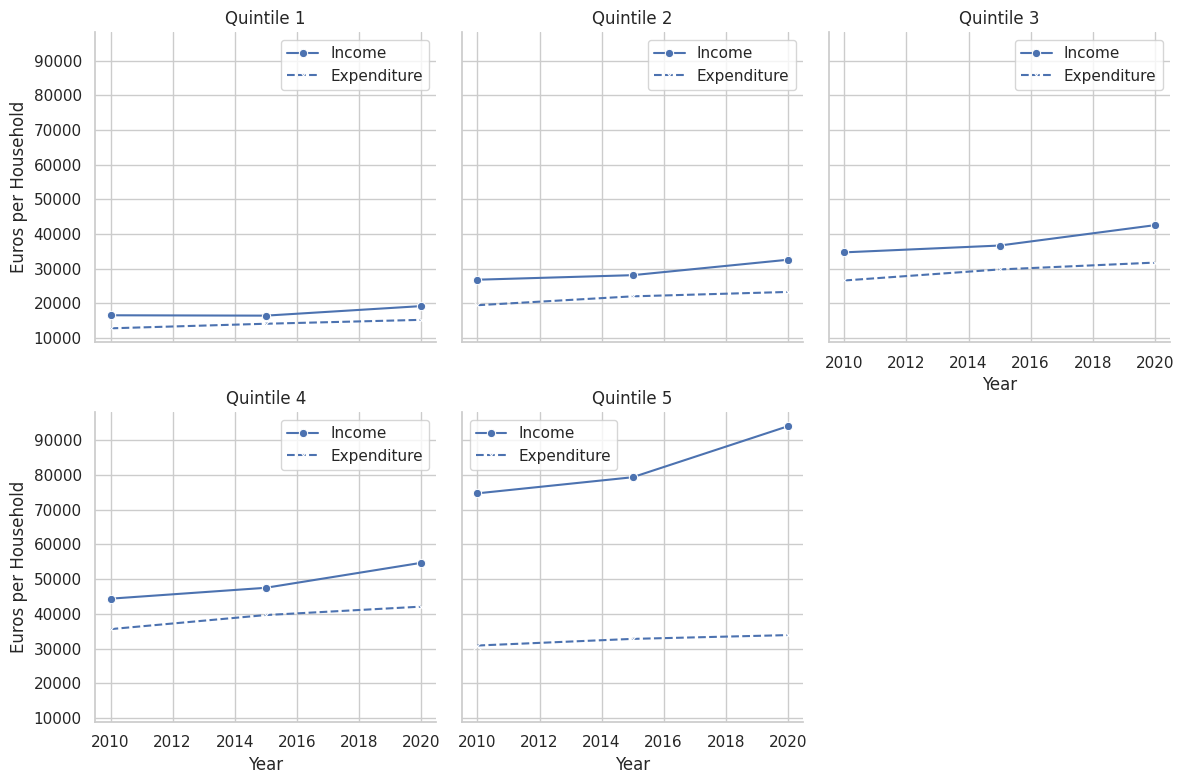

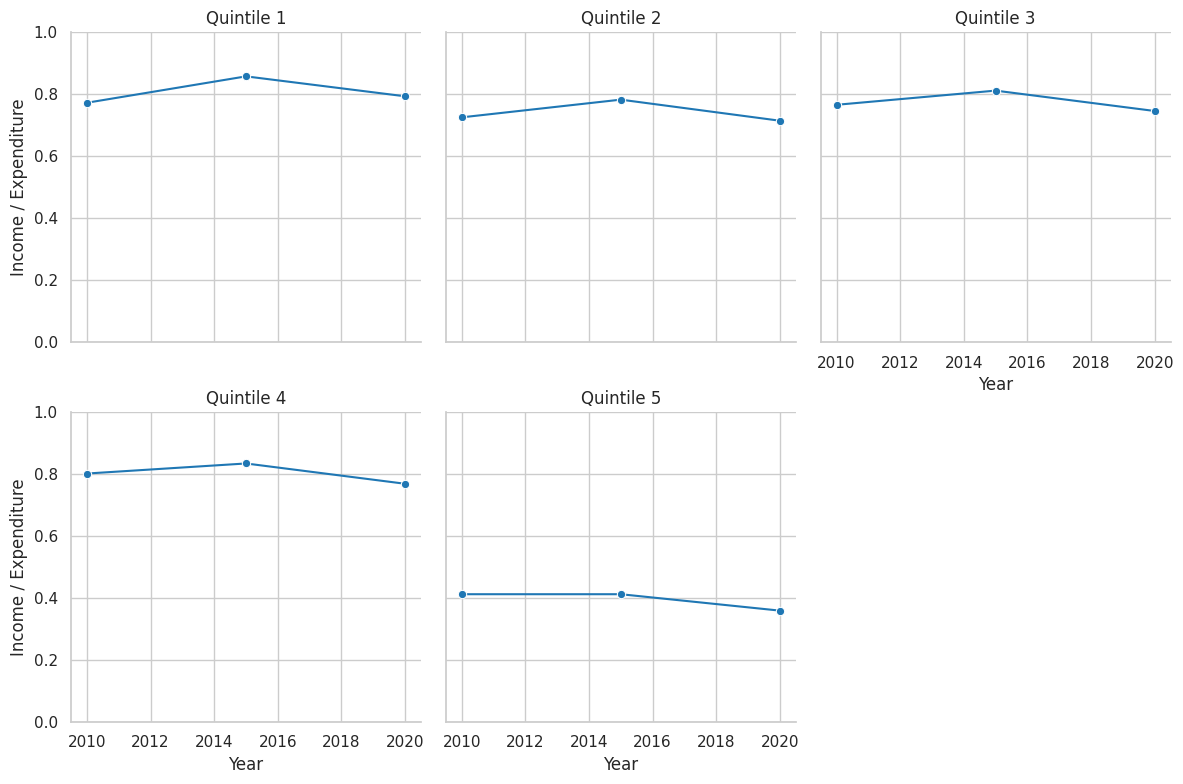

In [31]:

# Prepare dataframe for plotting
df_plot = df_compare.copy()
df_plot["Quintile"] = df_plot["Quintile"].astype(str)  # for better labeling

# Panel plot: MeanIncome vs MeanExpenditure per quintile
g = sns.FacetGrid(df_plot, col="Quintile", col_wrap=3, height=4, sharey=True)
g.map_dataframe(sns.lineplot, x="Year", y="MeanIncome", marker="o", label="Income")
g.map_dataframe(sns.lineplot, x="Year", y="MeanExpenditure", marker="x", linestyle="--", label="Expenditure")

# Add titles and labels
g.set_axis_labels("Year", "Euros per Household")
g.set_titles("Quintile {col_name}")
for ax in g.axes.flatten():
    ax.legend()

plt.tight_layout()
plt.show()

# Panel plot: Income/Expenditure ratio per quintile
g2 = sns.FacetGrid(df_plot, col="Quintile", col_wrap=3, height=4, sharey=True)
g2.map_dataframe(sns.lineplot, x="Year", y="Income_Exp_Ratio", marker="o", color="tab:blue")
g2.set_axis_labels("Year", "Income / Expenditure")
g2.set_titles("Quintile {col_name}")
plt.ylim(0,1)  # keep ratio readable
plt.tight_layout()
plt.show()

In [29]:
df_compare.to_csv("Germany_Household_Income_Expenditure.csv", index=False)
print("CSV exported: Germany_Household_Income_Expenditure.csv")

from google.colab import files

# Download the combined CSV
df_compare.to_csv("Germany_Household_Income_Expenditure.csv", index=False)
files.download("Germany_Household_Income_Expenditure.csv")

CSV exported: Germany_Household_Income_Expenditure.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
print("B6N - Total disposable income (millions EUR):")
print(df_income["TotalIncome_MIOEUR"].head())      # B6N

print("\nNumber of households (thousands):")
print(df_income["NumHouseholds_thousands"].head())    # hhld_num

print("\nExpenditure in PPS:")
print(df_exp["ExpPPS"].head())              # PPS

print("\nPPP conversion factor:")
print(df_exp["PPP"].head())                 # PPP

B6N - Total disposable income (millions EUR):
0    1449166
1    1471502
2    1504587
3    1490927
4    1525566
Name: TotalIncome_MIOEUR, dtype: int64

Number of households (thousands):
0    39188.5
1    39290.5
2    39646.2
3    39183.4
4    38679.3
Name: NumHouseholds_thousands, dtype: float64

Expenditure in PPS:
0    12180
1    13225
2    14119
3    18519
4    20622
Name: ExpPPS, dtype: int64

PPP conversion factor:
0    1.05118
1    1.06790
2    1.07968
3    1.05118
4    1.06790
Name: PPP, dtype: float64
